In [1]:
from os import walk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from PIL import Image
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from matplotlib import colormaps as cm
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

from sklearn.metrics import f1_score, recall_score, precision_score, r2_score
filterwarnings('ignore')
%matplotlib inline

In [2]:
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_HAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_HAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

DATA_JASON_PATH = 'SpamData/01_Processing/data-text.json'
DICTIONARY_PATH = 'SpamData/01_Processing/dictionary.csv'
DICTIONARY_SIZE = 2500

MASK_WHALE_PATH = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
MASK_SKULL_PATH = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
MASK_THUMBSUP_PATH = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
MASK_THUMBSDOWN_PATH = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

In [3]:
def body_extractor_generator(path):
    for root, subs, filenames in walk(path):
        filenames = filenames
        
    for filename in filenames:
        stream = open(path +'/'+ filename, encoding='latin-1')
        message = stream.readlines()
        stream.close()
            
        message_body = ''
        for line in message[message.index('\n')+1:]:
            message_body = message_body + line
                
        yield message_body, filename
                

In [4]:
def dataframe_generator(path, N, classification):
    bodies = []
    filenames = []
    counter = 0
    for o in body_extractor_generator(path):
        counter = counter + 1
        if counter < N:
            mes_body, filename = o
            bodies.append(mes_body)
            filenames.append(filename)
            
        else:
            return pd.DataFrame({'Email_body':bodies,
                                'Classification':classification}, index=filenames)
        

In [5]:
spam_emails = dataframe_generator(path=SPAM_1_PATH, N=500, classification=1)

In [6]:
spam_emails = spam_emails.append(dataframe_generator(path=SPAM_2_PATH, N=1396, classification=1))

In [7]:
ham_emails = dataframe_generator(path=EASY_HAM_1_PATH, N=2500, classification=0)
ham_emails = ham_emails.append(dataframe_generator(path=EASY_HAM_2_PATH, N=1400, classification=0))

In [8]:
data = pd.concat([ham_emails, spam_emails])

In [9]:
data.isnull().sum()

Email_body        0
Classification    0
dtype: int64

In [10]:
data['DOC_ID'] = range(0, len(data))

In [11]:
data['Filename'] = data.index

In [12]:
data.set_index('DOC_ID', inplace=True)

In [13]:
data

,Email_body,Classification,Filename
DOC_ID,,,
0,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0,00001.7c53336b37003a9286aba55d2945844c
1,"Martin A posted:\nTassos Papadopoulos, the Gre...",0,00002.9c4069e25e1ef370c078db7ee85ff9ac
2,Man Threatens Explosion In Moscow \n\nThursday...,0,00003.860e3c3cee1b42ead714c5c874fe25f7
3,Klez: The Virus That Won't Die\n \nAlready the...,0,00004.864220c5b6930b209cc287c361c99af1
4,"> in adding cream to spaghetti carbonara, whi...",0,00005.bf27cdeaf0b8c4647ecd61b1d09da613
...,...,...,...
5787,Did you hear? Interest rates have just been lo...,1,01395.cb33d1d72f42e4ab9268729917bf428b
5788,"<html>\n<head>\n<meta http-equiv=""content-type...",1,01396.e80a10644810bc2ae3c1b58c5fd38dfa
5789,This is a multi-part message in MIME format.\n...,1,01397.f75f0dd0dd923faefa3e9cc5ecb8c906


In [14]:
data.to_json(path_or_buf=DATA_JASON_PATH)

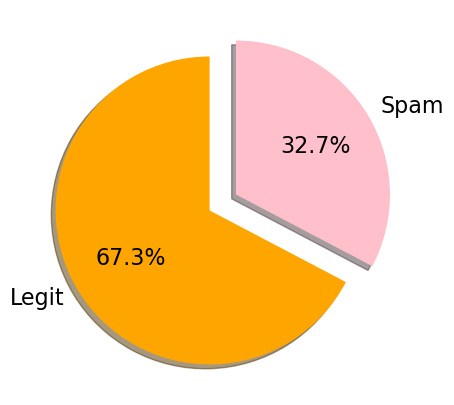

In [15]:
S_and_L = data['Classification'].value_counts()
fig, ax = plt.subplots(figsize=(7, 5))
labels = ['Legit', 'Spam']
colors = ['orange', 'pink']
nums = [S_and_L[0], S_and_L[1]]
ax.pie(nums, labels=labels, textprops={'fontsize':16}, startangle=90, autopct='%1.1f%%',
       colors=colors, shadow=True, explode=[0.1, 0.1])

plt.show()

In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mahdi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mahdi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
def preprocessing(text):
    soup = BeautifulSoup(text, 'html.parser')
    pure_text = soup.get_text()
    token_lower_text = word_tokenize(pure_text.lower())
    stemmer = PorterStemmer()
    
    filterd_words = []
    stop_words = stopwords.words('english')
    token_lower_text_nonstopwords = set(token_lower_text) - set(stop_words)
    for word in list(token_lower_text_nonstopwords):
        if word.isalpha():
            stemmed = stemmer.stem(word)
            filterd_words.append(stemmed)
            
    return filterd_words

In [19]:
data_3 = data.copy()

data_3['Naive_words'] = data_3['Email_body'].apply(preprocessing)

In [20]:
data_3

,Email_body,Classification,Filename,Naive_words
DOC_ID,,,,
0,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0,00001.7c53336b37003a9286aba55d2945844c,"[version, garrigu, hit, creat, time, command, ..."
1,"Martin A posted:\nTassos Papadopoulos, the Gre...",0,00002.9c4069e25e1ef370c078db7ee85ff9ac,"[plan, p, unsubscrib, yahoo, salonika, park, s..."
2,Man Threatens Explosion In Moscow \n\nThursday...,0,00003.860e3c3cee1b42ead714c5c874fe25f7,"[p, unsubscrib, press, thursday, near, yahoo, ..."
3,Klez: The Virus That Won't Die\n \nAlready the...,0,00004.864220c5b6930b209cc287c361c99af1,"[carri, mere, hold, press, thursday, harbing, ..."
4,"> in adding cream to spaghetti carbonara, whi...",0,00005.bf27cdeaf0b8c4647ecd61b1d09da613,"[p, nice, unsubscrib, yahoo, time, fraich, edi..."
...,...,...,...,...
5787,Did you hear? Interest rates have just been lo...,1,01395.cb33d1d72f42e4ab9268729917bf428b,"[delay, get, mortgag, free, hour, http, oblig,..."
5788,"<html>\n<head>\n<meta http-equiv=""content-type...",1,01396.e80a10644810bc2ae3c1b58c5fd38dfa,"[school, investig, unsubscrib, enrol, save, co..."
5789,This is a multi-part message in MIME format.\n...,1,01397.f75f0dd0dd923faefa3e9cc5ecb8c906,"[case, good, messag, mime, mail, profession, g..."


In [21]:
all_spam_emails_words = [word for l in data_3[data_3['Classification']==1]['Naive_words'] for word in l]


In [22]:
all_legit_emails_words = [word for l in data_3[data_3['Classification']==0]['Naive_words'] for word in l]

In [23]:
s = pd.Series(all_spam_emails_words)
l = pd.Series(all_legit_emails_words)

In [24]:
s.value_counts()[:10]

remov     1286
http      1174
email     1127
list      1125
click     1091
mail      1083
receiv    1062
pleas      980
get        822
free       803
dtype: int64

In [25]:
l.value_counts()[:10]

http      3829
use       2346
list      2068
mail      1681
get       1566
wrote     1373
one       1292
work      1255
like      1214
messag    1124
dtype: int64

In [26]:
spam_words_string = ''

for word in all_spam_emails_words:
    spam_words_string = spam_words_string + " " + word
    

In [27]:
legit_words_string = ''

for word in all_legit_emails_words:
    legit_words_string = legit_words_string + ' ' + word

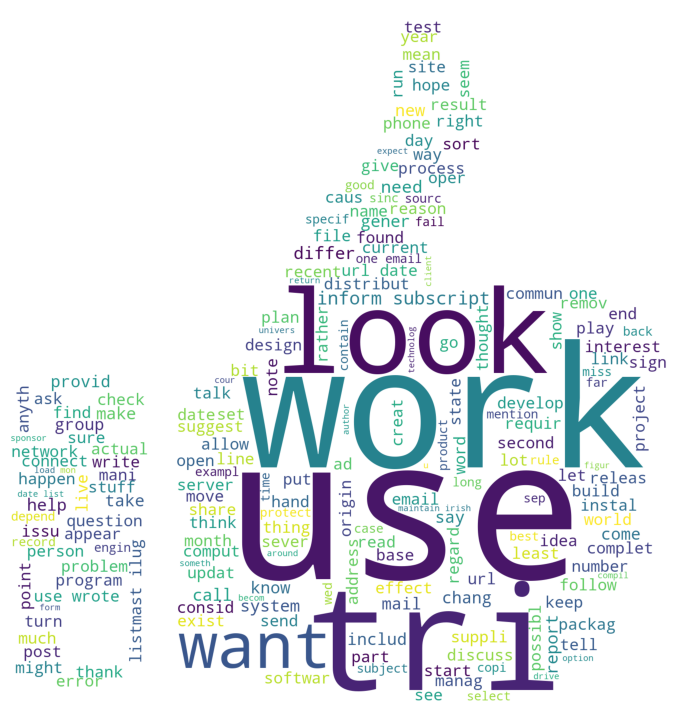

In [28]:
thumbs_up_icon = Image.open(MASK_THUMBSUP_PATH)
thumbs_up_mask = Image.new(mode='RGB', size=thumbs_up_icon.size, color=(255, 255, 255))
thumbs_up_mask.paste(thumbs_up_icon, box=thumbs_up_icon)

thumbs_up_mask = np.array(thumbs_up_mask)
legit_word_cloud = WordCloud(mask=thumbs_up_mask, background_color='white').generate(legit_words_string)

plt.figure(figsize=(14, 9))
plt.imshow(legit_word_cloud)
plt.axis('off')
plt.show()

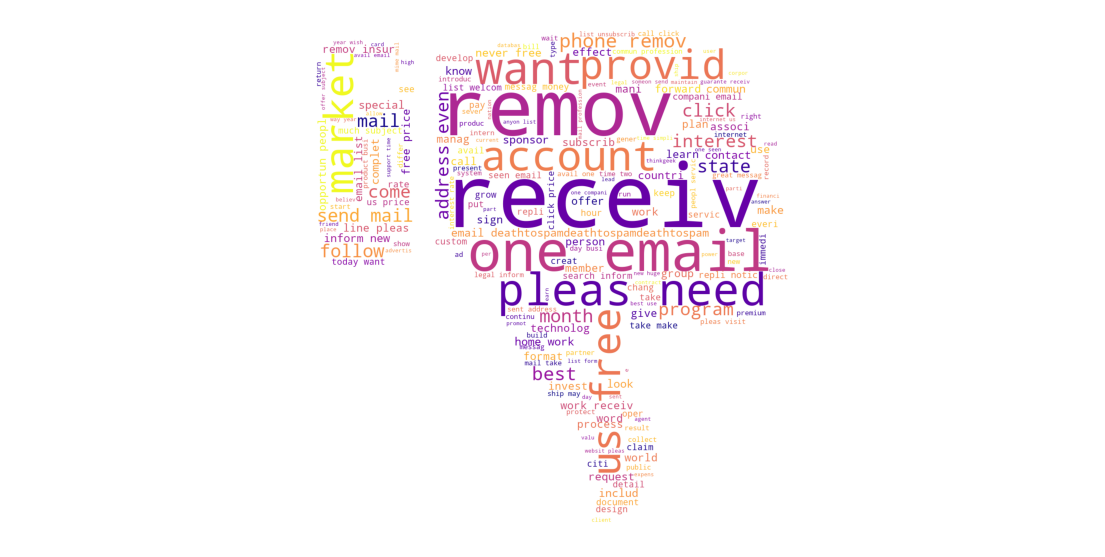

In [29]:
thumbs_down_icon = Image.open(MASK_THUMBSDOWN_PATH)
thumbs_down_mask = Image.new(mode='RGB', size=thumbs_down_icon.size, color=(255, 255, 255))
thumbs_down_mask.paste(thumbs_down_icon, box=thumbs_down_icon)

thumbs_down_mask = np.array(thumbs_down_mask)
spam_word_cloud = WordCloud(mask=thumbs_down_mask, background_color='white', colormap=cm.get_cmap('plasma')).generate(spam_words_string)

plt.figure(figsize=(14, 9))
plt.imshow(spam_word_cloud)
plt.axis('off')
plt.show()

In [30]:
all_naive_words = data['Email_body'].apply(preprocessing)

In [31]:
flatten_all_naive_words = [word for r in all_naive_words for word in r]

In [32]:
vocab = pd.Series(flatten_all_naive_words)

In [33]:
frequently_words = vocab.value_counts()[0:DICTIONARY_SIZE].index

In [34]:
dictionary = pd.DataFrame({'VOCABS':frequently_words,
                          'VOCAB_IDs':list(range(0, DICTIONARY_SIZE))})
dictionary.set_index('VOCAB_IDs')

,VOCABS
VOCAB_IDs,
0,http
1,list
2,use
3,mail
4,get
...,...
2495,justifi
2496,architect
2497,season


In [35]:
dictionary.to_csv(DICTIONARY_PATH)

In [36]:
dictionary

,VOCABS,VOCAB_IDs
0,http,0
1,list,1
2,use,2
3,mail,3
4,get,4
...,...,...
2495,justifi,2495
2496,architect,2496
2497,season,2497
2498,kre,2498


In [37]:
data_3['Naive_words'].shape[0]

5792

In [38]:
def occurances(dictionary, naive_words):
    
    nr_features = dictionary.shape[0]
    
    occurances = np.zeros(shape=(1, nr_features))
    
    for i in range(nr_features):
  
        occurances[0][i] = naive_words.count(dictionary['VOCABS'][i])
   
    return occurances

In [39]:
pd.DataFrame(occurances(dictionary=dictionary, naive_words=data_3['Naive_words'][56]))

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
data_1 = pd.DataFrame({'DOC_ID':data_3.index,
                       'Naive_words':data_3['Naive_words'],
                       'Target':data_3['Classification']})
data_1

,DOC_ID,Naive_words,Target
DOC_ID,,,
0,0,"[version, garrigu, hit, creat, time, command, ...",0
1,1,"[plan, p, unsubscrib, yahoo, salonika, park, s...",0
2,2,"[p, unsubscrib, press, thursday, near, yahoo, ...",0
3,3,"[carri, mere, hold, press, thursday, harbing, ...",0
4,4,"[p, nice, unsubscrib, yahoo, time, fraich, edi...",0
...,...,...,...
5787,5787,"[delay, get, mortgag, free, hour, http, oblig,...",1
5788,5788,"[school, investig, unsubscrib, enrol, save, co...",1
5789,5789,"[case, good, messag, mime, mail, profession, g...",1


In [41]:
x_train, x_test, y_train, y_test = train_test_split(data_1['Naive_words'], data_1['Target'], test_size=0.3, random_state=42)

In [42]:
def full_matrix(dictionary, data, target=1):
    '''dictionary : The vocabularies that we use as features
       data : Pandas Series (x_train or x_test) that contains DOC_ID as index and list of naive words
       target : Pandas Series that contains DOC_ID as index and labels(0, 1)
    '''
    nr_columns = dictionary.shape[0]
    nr_rows = data.shape[0]
    DOC_IDs = data.index
    VOCAB_IDs = dictionary['VOCAB_IDs']
    
    zeros = np.zeros(shape=(nr_rows, nr_columns), dtype='int' )
    occurances = pd.DataFrame(zeros, index=data.index)
    occurances['2500'] = target
    occurances.rename(columns={'2500':'Target'}, inplace=True)   
    for DOC_ID in DOC_IDs:
        for VOCAB_ID in VOCAB_IDs:
            if dictionary['VOCABS'].loc[VOCAB_ID] in set(data.loc[DOC_ID]):
                occurances[VOCAB_ID].loc[DOC_ID] = data.loc[DOC_ID].count(dictionary['VOCABS'].loc[VOCAB_ID])
            else:
                continue
           
    return occurances
    

In [43]:
#train_matrix = full_matrix(dictionary=dictionary, data=x_train, target=y_train)

In [44]:
#train_matrix.to_csv('train_matrix.csv')
train_matrix = pd.read_csv('train_matrix.csv', index_col='DOC_ID')


In [45]:
#test_matrix = full_matrix(dictionary=dictionary, data=x_test, target=y_test)

In [46]:
#test_matrix.to_csv('test_matrix.csv')
test_matrix = pd.read_csv('test_matrix.csv', index_col='DOC_ID')


In [47]:
train_data = pd.DataFrame({'Naive_words':x_train, 'target':y_train})

In [48]:
train_data

,Naive_words,target
DOC_ID,,
2228,"[url, annoy, mac, date, ui, user, better, wind...",0
1151,"[snap, current, version, hit, final, start, fa...",0
4110,"[electron, unsubscrib, research, feel, user, w...",1
3258,"[sever, unseen, new, laboratori, list, univers...",0
3317,"[dozen, time, tell, find, next, useless, innov...",0
...,...,...
3772,"[sysadmin, aaron, never, everyth, repeatedli, ...",0
5191,"[password, step, get, known, e, adult, free, f...",1
5226,"[email, deathtospamdeathtospamdeathtospam, new...",1


In [52]:
file = open('email_ex.txt', encoding='utf8')

text = file.read()

print(type(text))

<class 'str'>


## Bayes approach

In [62]:
train_matrix

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Target
DOC_ID,,,,,,,,,,,,,,,,,,,,,
2228,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1151,1,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4110,1,1,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3258,2,1,0,2,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3317,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5191,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5226,2,1,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [63]:
def P_spam_words(word_occurances):
    
    nr_all_words = word_occurances.drop(['Target'], axis=1).sum().sum()
    nr_spam_words = word_occurances.drop(['Target'], axis=1)[train_matrix['Target']==1].sum().sum()
    
    
    P_words = word_occurances.drop('Target', axis=1).sum()/nr_all_words
    P_spam_email = len(word_occurances[word_occurances['Target']==1])/len(word_occurances)
    
    features = word_occurances.drop('Target', axis=1).columns
    
    P_words_spam = np.zeros(shape=(len(features),))
    P_spam_words = np.zeros(shape=(len(features),))
    
    for i in range(len(features)):
        P_words_spam[i] = word_occurances[features[i]][word_occurances['Target']==1].sum()/nr_spam_words
        P_spam_words[i] = (P_words_spam[i] * P_spam_email)/P_words[i]
    
    return P_spam_words.reshape(len(features), 1) + 0.01
    

In [64]:
def P_legit_words(word_occurances):
    
    nr_all_words = word_occurances.drop(['Target'], axis=1).sum().sum()
    nr_legit_words = word_occurances.drop(['Target'], axis=1)[train_matrix['Target']==0].sum().sum()
    
    P_words = word_occurances.drop('Target', axis=1).sum()/nr_all_words
    P_legit_email = len(word_occurances[word_occurances['Target']==1])/len(word_occurances)
    
    features = word_occurances.drop('Target', axis=1).columns
    
    P_word_legit = np.zeros(shape=(len(features),))
    P_legit_word = np.zeros(shape=(len(features),))
    
    for i in range(len(features)):
        P_word_legit[i] = word_occurances[features[i]][word_occurances['Target']==0].sum()/nr_legit_words
        P_legit_word[i] = (P_word_legit[i] * P_legit_email)/P_words[i]
        
    return P_legit_word.reshape(len(features), 1) + 0.01

In [65]:
train_matrix

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Target
DOC_ID,,,,,,,,,,,,,,,,,,,,,
2228,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1151,1,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4110,1,1,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3258,2,1,0,2,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3317,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5191,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5226,2,1,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [66]:
def spam_or_legit(P_spam_words, P_legit_words, data, ID):
    
    occur = np.array(data.drop('Target', axis=1).loc[ID]).reshape(1, 2500)
    
    P_spam_multiply_occur = np.matmul(P_spam_words, occur)
    P_legit_multiply_occur = np.matmul(P_legit_words, occur)
    
    diag_spam = np.diag(P_spam_multiply_occur)
    diag_legit = np.diag(P_legit_multiply_occur)
    
    if np.prod(pd.Series(diag_spam)[pd.Series(diag_spam)>0]) > np.prod(pd.Series(diag_legit)[pd.Series(diag_legit)>0]):
        return 1
    else:
        return 0
 
    

In [67]:
Ps = P_spam_words(train_matrix)
Pl = P_legit_words(train_matrix)

In [68]:
%%time
spam_or_legit(P_spam_words=Ps, P_legit_words=Pl, data=test_matrix ,ID=1891)

CPU times: total: 62.5 ms
Wall time: 80.8 ms


0

In [69]:
y_preds = []
for i in test_matrix.index:
    
    y_preds.append(spam_or_legit(P_spam_words=Ps, P_legit_words=Pl,data=test_matrix, ID=i))
    

In [70]:
y_preds = np.array(y_preds)

In [71]:
recall_score(y_true=test_matrix['Target'], y_pred=y_preds)

0.9312169312169312